<a href="https://colab.research.google.com/github/mNiedbalski/lstm-stock-predicting/blob/main/LSTM_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [202]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

Useful for stopping model when more epochs will result in worse results

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading file

In [ ]:
file_path = '/content/drive/My Drive/LSTM_Bitcoin_Predicting_Project/btc_15m_data_2018_2024.csv'

# Code

In [ ]:
btcdf = pd.read_csv(file_path)

In [ ]:
print('Total number of days present in the dataset: ',btcdf.shape[0])
print('Total number of fields present in the dataset: ',btcdf.shape[1])

Total number of days present in the dataset:  242831
Total number of fields present in the dataset:  12


# Filtering useful columns

In [ ]:
btcdf = btcdf [['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time']]

In [ ]:
btcdf.tail()

,Open time,Open,High,Low,Close,Volume,Close time
242826,2024-12-09 23:30:00,97425.20,97469.00,97190.70,97430.01,310.91848,2024-12-09 23:44:59.999000
242827,2024-12-09 23:45:00,97430.00,97482.74,97260.00,97276.47,265.18128,2024-12-09 23:59:59.999000
242828,2024-12-10 00:00:00,97276.48,97309.00,97000.00,97297.17,547.40261,2024-12-10 00:14:59.999000
242829,2024-12-10 00:15:00,97297.18,97600.00,97168.00,97573.03,411.94772,2024-12-10 00:29:59.999000
242830,2024-12-10 00:30:00,97573.03,98138.00,97480.01,97707.69,546.51797,2024-12-10 00:44:59.999000


# Problem analysis
In this project, I will be training bitcoin on data from one year, because price differences between years are extreme. This way, model will get used to recent prices. It would be unwise to teach model that the price can jump from 20 000 USDT to 100 000 USDT in one year, because we aren't taking into account the periodicity and things like that happen for a clear reason. We will be training our model how to predict it's local environment, for short term trading instead of long term goals.

In [ ]:
closedf = btcdf[['Open time', 'Close']].rename(columns={'Open time': 'Date'})
closedf['Date'] = pd.to_datetime(closedf['Date'])

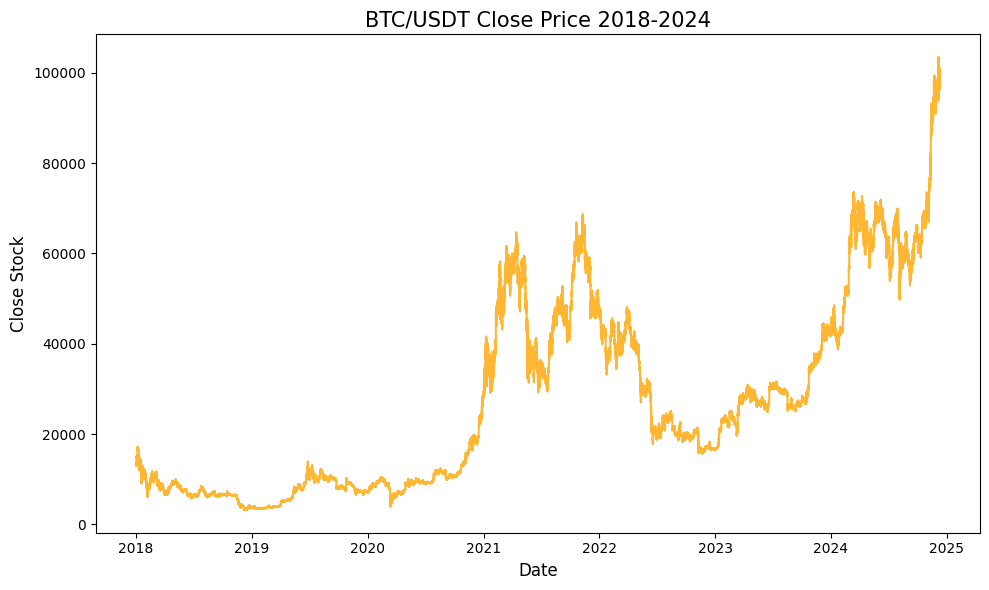

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(closedf['Date'], closedf['Close'], linestyle='-', linewidth=1.5, color='orange', alpha=0.8)
plt.title('BTC/USDT Close Price 2018-2024', fontsize=15, color='black')
plt.xlabel('Date', fontsize=12, color='black')
plt.ylabel('Close Stock', fontsize=12, color='black')
plt.grid(False)
plt.gca().set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=10, colors='black')
plt.tight_layout()
plt.show()

Taking periodicality into account, we can see distinguish recurring bull and bear cycles. Bitcoin halving occurs every four years, which halves rewards for mining Bitcoin. If supply dwindles, the demand rises, therefore bull cycle begins.

Let's train model on previous bull cycle 2020-2022 to prepare for 2024-2026 bull cycle. I will be considering data periods from 2021 to 2022, since it's the most adequate. Big price swings can impact negatively model accuracy.

# Slicing data

In [ ]:
closedf = closedf[(closedf['Date'] >= '2020-01-01') & (closedf['Date'] <= '2021-01-01')]

total_candles = closedf.shape[0]
total_days = total_candles / 96  # 96 15-minute candles in a day

print("Total data for prediction: ", total_days)

Total data for prediction:  365.1458333333333


Stuff for reassigning labels

In [ ]:
datesdf = btcdf[['Open time', 'Close']].rename(columns={'Open time': 'Date'})
datesdf['Date'] = pd.to_datetime(datesdf['Date'])
datesdf = datesdf[(datesdf['Date'] >= '2020-01-01' ) & ( datesdf['Date'] <= '2021-01-01')]
total_candles = datesdf.shape[0]
total_days = total_candles / 96  # 96 15-minute candles in a day

print("Total data for prediction: ", total_days)

Total data for prediction:  365.1458333333333


# Visualizing training data and period to predict


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Normalization

In [ ]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(35054, 1)


# Slicing into training set and testing set

In [ ]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (21032, 1)
test_data:  (14022, 1)


In [ ]:
def create_sequences(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (21016, 15)
y_train:  (21016,)
X_test:  (14006, 15)
y_test (14006,)


Reshaping for LSTM input [samples,time steps, features]

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (21016, 15, 1)
X_test:  (14006, 15, 1)


# Building model

In [ ]:
model = Sequential ([
    LSTM(10,input_shape = (None, 1), activation="relu"),
    Dense(1),
])

model.compile(loss="mean_squared_error", optimizer = "adam")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



# Training

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
    )


Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0073 - val_loss: 1.1143
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 2.2325e-05 - val_loss: 0.1255
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 1.0882e-05 - val_loss: 0.0527
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 9.3683e-06 - val_loss: 0.0367
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 9.1012e-06 - val_loss: 0.0268
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 8.9329e-06 - val_loss: 0.0251
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 8.9579e-06 - val_loss: 0.0171
Epoch 8/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.0264e-06 - val_loss: 0.0107
Epoch 9/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 7.5391e-06 - val_loss: 0.0058
Epoch 10/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 8.0360e-06 - val_loss: 0.0034
Epoch 11/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.4799e-06 - val_loss: 0.

Visualizing loss

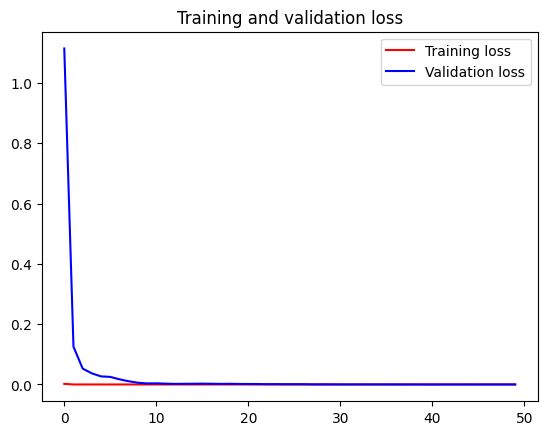

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


((21016, 1), (14006, 1))

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(original_ytrain, train_predict)
test_mape = mean_absolute_percentage_error(original_ytest, test_predict)

print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

In [205]:
# Evaluation metrices
print("** TRAIN METRICS **")
print("RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Mean squared error: ", mean_squared_error(original_ytrain,train_predict))
print("Mean absolute error: ", mean_absolute_error(original_ytrain,train_predict))
print("Mean absolute percentage error:", mean_absolute_percentage_error(original_ytrain, train_predict), "%")
print("Explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Mean gamma deviance: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Mean poisson deviance: ", mean_poisson_deviance(original_ytrain, train_predict))
print("R²:", r2_score(original_ytrain, train_predict))
print('\n')
print("** TEST METRICS **")
print("RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Mean squared error: ", mean_squared_error(original_ytest,test_predict))
print("Mean absolute error: ", mean_absolute_error(original_ytest,test_predict))
print("Mean absolute percentage error:", mean_absolute_percentage_error(original_ytest, test_predict), "%")
print("Explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("Mean gamma deviance: ", mean_gamma_deviance(original_ytest, test_predict))
print("Mean poisson deviance: ", mean_poisson_deviance(original_ytest, test_predict))
print("R²:", r2_score(original_ytest, test_predict))

** TRAIN METRICS **
RMSE:  37.907168743717456
Mean squared error:  1436.95344216467
Mean absolute error:  20.766249698890135
Mean absolute percentage error: 0.25723463582127715 %
Explained variance regression score: 0.9992135653872033
Mean gamma deviance:  2.856156149677072e-05
Mean poisson deviance:  0.19495324059548072
R²: 0.9992119110739796


** TEST METRICS **
RMSE:  83.6505042206155
Mean squared error:  6997.406856363211
Mean absolute error:  48.2438183942373
Mean absolute percentage error: 0.2850232105003255 %
Explained variance regression score: 0.9996733544327021
Mean gamma deviance:  1.804593649304682e-05
Mean poisson deviance:  0.3390621293613349
R²: 0.9996688017215554


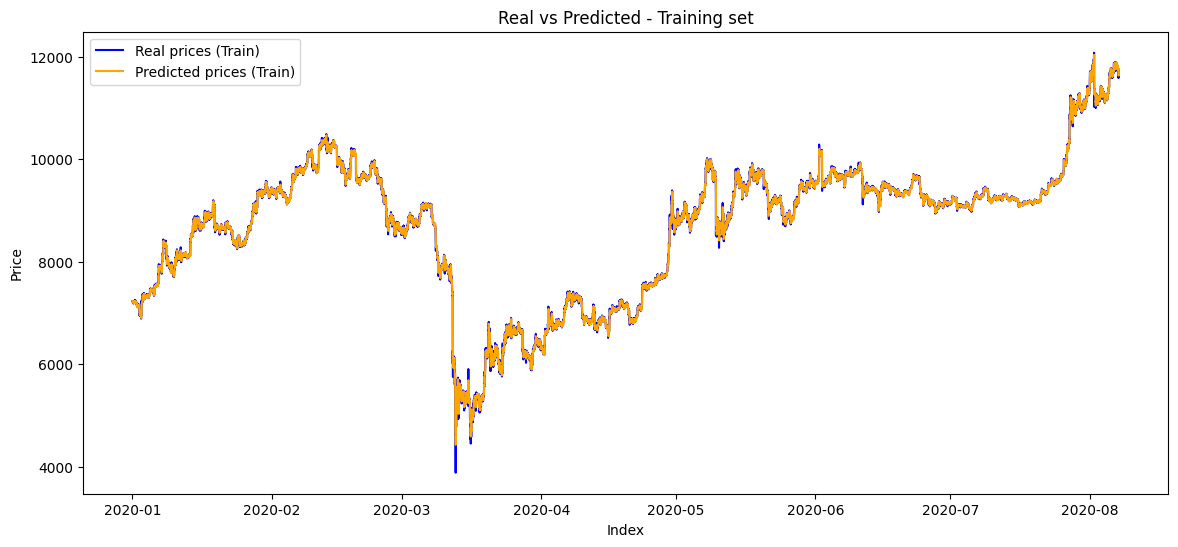

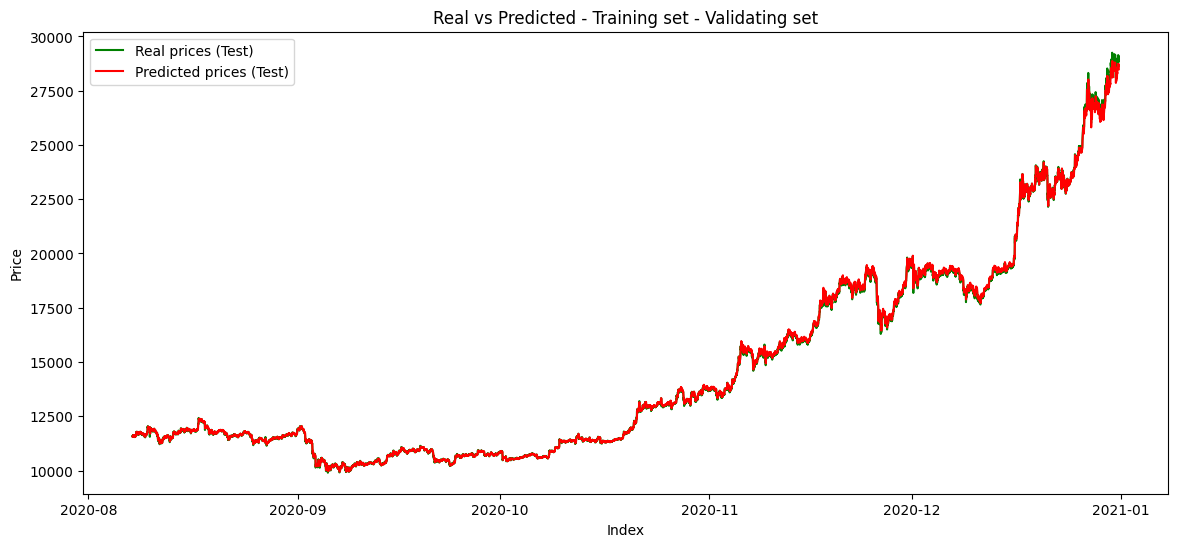

In [ ]:
train_dates = datesdf['Date'][:len(original_ytrain)].reset_index(drop=True)
test_dates = datesdf['Date'][len(original_ytrain):len(original_ytrain) + len(original_ytest)].reset_index(drop=True)

# Train data visualized
plt.figure(figsize=(14, 6))
plt.plot(train_dates, original_ytrain, label="Real prices (Train)", color="blue")
plt.plot(train_dates, train_predict, label="Predicted prices (Train)", color="orange")
plt.title("Real vs Predicted - Training set")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

# Test data visualized
plt.figure(figsize=(14, 6))
plt.plot(test_dates, original_ytest, label="Real prices (Test)", color="green")
plt.plot(test_dates, test_predict, label="Predicted prices (Test)", color="red")
plt.title("Real vs Predicted - Training set - Validating set")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()
